# NOTEBOOK NAME
Created by: Thomas Durand-Texte, 2023

# Import des packages et données
## import des packages

In [1]:
import os

import pandas as pd
import numpy as np
# import dask as dd
pd.set_option("display.max_columns", 200)
import datetime as dt
import scipy.stats as st

from sklearn import model_selection, metrics, preprocessing


import matplotlib.pyplot as plt
import seaborn as sns

cm = 1./2.54

## Paramètres graphiques et fonctions utiles

In [2]:
import subprocess

white_font = True
def set_theme( white_font=True ):
    """ set_theme( white_font=True ) """
    if white_font: wht, grey, blck = '0.84' , '0.5', 'k'
    else: wht, grey, blck = 'k', '0.5', '0.84'
    rc = { 'figure.facecolor':(0.118,)*3,
            'axes.labelcolor':wht,
            'axes.edgecolor':wht,
            'axes.facecolor':(0,0,0,0),
            'text.color':'white',
            'text.usetex':False,
            'text.latex.preamble':r'\usepackage[cm]{sfmath} \usepackage{amsmath}' ,
            'font.family': 'sans-serif' ,
            'font.sans-serif': 'DejaVu Sans' ,
            'xtick.color':wht,
            'ytick.color':wht,
            "axes.grid" : True,
            "grid.color": (0.7,)*3,
            "grid.linewidth": 0.4,
            "grid.linestyle": (10,5),
            'legend.edgecolor':'0.2',
            'legend.facecolor':(0.2,0.2,0.2,0.6),
            # 'legend.framealpha':'0.6',
            'pdf.fonttype':42,
            'savefig.format':'pdf',
            'savefig.transparent':True,
            'figure.dpi':150, # for better agreemet figsize vs real size
        }

    sns.set_theme( 'notebook' , rc=rc )
    return


def make_folder( path_folder ):
    path_folder = path_folder.__str__()
    try:
        if os.path.isdir( path_folder ) : return
        os.makedirs(path_folder)
    except OSError:
        pass
    return

def concat_folders(*args, **kwargs):
    """ concat_folders(*args, **kwargs)
        concatenate folders in args (strings) """
    sPath = ''
    for arg in args:
        if arg == '..': sPath = sPath[:sPath[:-1].rfind(os.sep)+1]
        else: sPath += arg
        if sPath[-1] != os.sep: sPath += os.sep
    return sPath

class Path(object):
    """ Path( s_in='', s_lim=None)
        create a path to the string s_in (default is current path)
        and stops after s_lim """
    n_Path = 0
    def __init__(self, s_in='', s_lim=None):
        """docstring."""
        if s_in == '': s_in = os.getcwd()
        if not s_lim is None:
            if s_lim in s_in:
                s_in = s_in[ :s_in.index( s_lim ) + len(s_lim) ]
        self.sPath = concat_folders(s_in)
        self.N = Path.n_Path
        Path.n_Path += 1

    def __add__(self, other):
        """ Path + str : return str """
        if isinstance(other, str): return self.sPath + other

    def __truediv__(self, other):
        """ Path / str : return path concatenated"""
        if isinstance(other, str): return Path(concat_folders(self.sPath, other))

    def __invert__(self):
        """ ~Path : return str of the path """
        return self.sPath

    def __str__(self):
        """ __str__ return str of the path """
        return self.sPath
    # __str__ #

    def makedir( self ):
        return make_folder( self )


def gs_opt( filename ):
    """ otpimisation of a pdf file with gosthscript """
    filenameTmp = filename.replace('.pdf', '') + '_tmp.pdf'
    gs = ['gs',
            '-sDEVICE=pdfwrite',
            '-dEmbedAllFonts=true',
            '-dSubsetFonts=true',             # Create font subsets (default)
            '-dPDFSETTINGS=/prepress',        # Image resolution
            '-dDetectDuplicateImages=true',   # Embeds images used multiple times only once
            '-dCompressFonts=true',           # Compress fonts in the output (default)
            '-dNOPAUSE',                      # No pause after each image
            '-dQUIET',                        # Suppress output
            '-dBATCH',                        # Automatically exit
            '-sOutputFile='+filenameTmp,      # Save to temporary output
            filename]                         # Input file

    subprocess.run(gs)                                      # Create temporary file
    subprocess.run( 'rm -f ' + filename, shell=True)            # Delete input file
    subprocess.run( 'mv -f ' + filenameTmp + " " + filename, shell=True) # Rename temporary to input file

def savefig( fig, savename, **kwargs ):
    """ savefig( fig, savename, **kwargs )
        Saves a figure with kwargs (fig.savefig( savename, **kwargs) ).
        A check is done first to determine if a folder has to be created according to savename.
        Finally, if the file is saved as .pdf, gosthscript optimisation is performed. """
    if os.sep in savename: make_folder( savename[:savename.rindex(os.sep)] )
    fig.savefig( savename, **kwargs )
    savename += '.pdf'
    if os.path.isfile( savename ): gs_opt( savename )


def image_size_from_width_and_shape( width: float, shape: tuple, ymargin=0. ):
    """ return tuple (width, height) corresponding to image shape """
    return width, width*shape[0]/shape[1]+ymargin

def image_size_from_height_and_shape( height: float, shape: tuple, xmargin=0. ):
    """ return tuple (width, height) corresponding to image shape """
    return height*shape[1]/shape[0]+xmargin, height


set_theme()
del set_theme

## Chargement des données

If the true label is not known in advance(as in your case), then K-Means clustering can be evaluated using either Elbow Criterion or Silhouette Coefficient.

Elbow Criterion Method:

The idea behind elbow method is to run k-means clustering on a given dataset for a range of values of k (num_clusters, e.g k=1 to 10), and for each value of k, calculate sum of squared errors (SSE).

After that, plot a line graph of the SSE for each value of k. If the line graph looks like an arm - a red circle in below line graph (like angle), the "elbow" on the arm is the value of optimal k (number of cluster). Here, we want to minimize SSE. SSE tends to decrease toward 0 as we increase k (and SSE is 0 when k is equal to the number of data points in the dataset, because then each data point is its own cluster, and there is no error between it and the center of its cluster).

So the goal is to choose a small value of k that still has a low SSE, and the elbow usually represents where we start to have diminishing returns by increasing k.

Let's consider iris datasets,

{1: 594.8006666666665,
 2: 133.46431822602605,
 3: 72.01678092289548,
 4: 55.45436652661065,
 5: 40.57379509803921,
 6: 33.250728864272986,
 7: 30.684303210678213,
 8: 27.864397309561785,
 9: 25.99767111908559}

sse[k_min]: 72.01678092289548


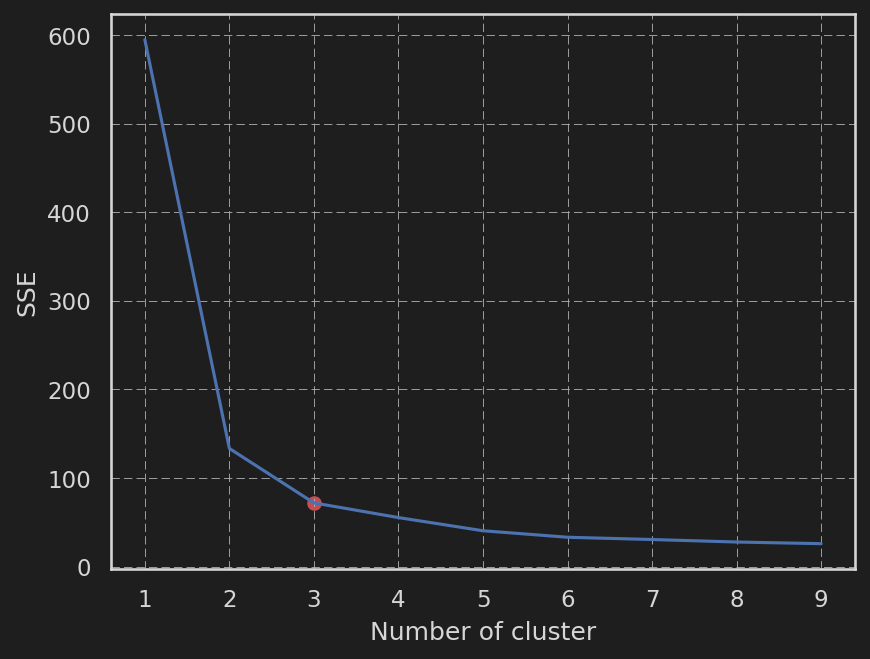

In [14]:
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

iris = load_iris()
X = pd.DataFrame(iris.data, columns=iris['feature_names'])
#print(X)
data = X[['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)']]

sse = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000, n_init='auto').fit(data)
    data["clusters"] = kmeans.labels_
    #print(data["clusters"])
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))

display( sse )
k_min = 3
print('sse[k_min]:', sse[k_min])
plt.plot( k_min, sse[k_min], 'ro', zorder=0)

plt.plot()
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()